In [1]:
import sys

sys.path.append("../..")

In [2]:
import logging
from argparse import Namespace

import torch
import matplotlib.pyplot as plt

from emgrep.datasets.EMGRepDataloader import get_dataloader
from emgrep.datasets.RepresentationsDataset import RepresentationDataset
from emgrep.models.cpc_model import CPCModel, CPCEncoder, CPCAR

# from emgrep.train_classifier import train_classifier
from emgrep.train_classifier_new import train_classifier

In [3]:
args = {
    "data": "../../data/01_raw",
    "device": "cpu",
    "output_dir": "logs",
    "n_subjects": 5,
    "n_days": 5,
    "n_times": 2,
    "positive_mode": "none",
    "val_idx": 1,
    "test_idx": 2,
    "seq_len": 3000,
    "seq_stride": 3000,
    "block_len": 300,
    "block_stride": 300,
    "batch_size": 64,
    "num_workers": 0,
    "encoder_dim": 256,
    "ar_dim": 256,
    "ar_layers": 2,
    "cpc_k": 5,
    "epochs_cpc": 1,
    "lr_cpc": 0.0002,
    "weight_decay_cpc": 0.0,
    "epochs_classifier": 50,
    "lr_classifier": 0.01,
    "batch_size_classifier": 64,
    "debug": True,
    "log_dir": "../../logs/none_1_2/2023-05-03_13-15-11",
    "log_to_file": False,
    "wandb": False,
}

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s %(levelname)s %(message)s",
)

args = Namespace(**args)

In [4]:
enc = CPCEncoder(16, args.encoder_dim)
ar = CPCAR(args.encoder_dim, args.ar_dim, args.ar_layers)

model = CPCModel(enc, ar)

checkpoint = "../../logs/logs/none_1_2/2023-05-03_11-28-23/checkpoints/best_model.pt"

model.load_state_dict(torch.load(checkpoint, map_location=args.device))

<All keys matched successfully>

In [5]:
rep_dataloader = get_dataloader(args, block_stride=True)
representations = {
    "train": RepresentationDataset(model=model, dataloader=rep_dataloader["train"], args=args),
    "val": RepresentationDataset(model=model, dataloader=rep_dataloader["val"], args=args),
    "test": RepresentationDataset(model=model, dataloader=rep_dataloader["test"], args=args),
}
del rep_dataloader

2023-05-04 15:09:30,959 INFO Loading train dataset...
Loading train dataset: 100%|████████████████████████████████████████| 30/30 [00:42<00:00,  1.41s/it]
2023-05-04 15:10:31,299 INFO Loading val dataset...
Loading val dataset: 100%|██████████████████████████████████████████| 10/10 [00:14<00:00,  1.45s/it]
2023-05-04 15:10:49,203 INFO Loading test dataset...
Loading test dataset: 100%|█████████████████████████████████████████| 10/10 [00:12<00:00,  1.29s/it]
2023-05-04 15:11:05,207 INFO Train samples: 142628
2023-05-04 15:11:05,207 INFO Val   samples: 47567
2023-05-04 15:11:05,208 INFO Test  samples: 43431
Generating Embeddings: 100%|████████████████████████████████████| 2229/2229 [12:25<00:00,  2.99it/s]
2023-05-04 15:23:33,220 DEBUG Data shape:   torch.Size([142628, 10, 256])
2023-05-04 15:23:33,224 DEBUG Labels shape: torch.Size([142628, 10])
2023-05-04 15:23:33,235 DEBUG Mapping labels [0, 1, 3, 4, 6, 9, 10, 11] to [0, 1, 2, 3, 4, 5, 6, 7]
Generating Embeddings: 100%|███████████████

In [6]:
metrics = train_classifier(representations, pred_block=-1, args=args)

logging.info(f"Train accuracy: {metrics['train']['accuracy']:.3f}")
logging.info(f"Val accuracy:   {metrics['val']['accuracy']:.3f}")
logging.info(f"Test accuracy:  {metrics['test']['accuracy']:.3f}")

2023-05-04 15:31:27,260 INFO Training the classifier...
2023-05-04 15:31:27,262 DEBUG Number of classes: 8
Training classifier: 100%|██████████| 50/50 [03:02<00:00,  3.66s/it, train loss=1.82, val loss=1.86]
2023-05-04 15:34:31,622 INFO Train classification report:
              precision    recall  f1-score   support

           0       0.74      0.93      0.82     41124
           1       0.26      0.25      0.25     14572
           3       0.30      0.24      0.27     14362
           4       0.36      0.31      0.33     14577
           6       0.23      0.30      0.26     14362
           9       0.26      0.29      0.27     14852
          10       0.20      0.01      0.02     14017
          11       0.27      0.30      0.28     14762

    accuracy                           0.44    142628
   macro avg       0.33      0.33      0.31    142628
weighted avg       0.40      0.44      0.41    142628

2023-05-04 15:34:31,809 INFO Train confusion matrix:
[[38185   490   142   383   18

In [7]:
metrics = {
    "train": [],
    "val": [],
    "test": []
}

for pred_block in range(1, 11):
    m = train_classifier(representations, pred_block=-pred_block, args=args)

    metrics["train"].append(m["train"]["accuracy"])
    metrics["val"].append(m["val"]["accuracy"])
    metrics["test"].append(m["test"]["accuracy"])

2023-05-04 15:34:32,767 INFO Training the classifier...
2023-05-04 15:34:32,767 DEBUG Number of classes: 8
Training classifier: 100%|██████████| 50/50 [02:35<00:00,  3.11s/it, train loss=2.17, val loss=2.17]
2023-05-04 15:37:09,397 INFO Train classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     41124
           1       0.00      0.00      0.00     14572
           3       0.00      0.00      0.00     14362
           4       0.00      0.00      0.00     14577
           6       0.00      0.00      0.00     14362
           9       0.10      1.00      0.19     14852
          10       0.00      0.00      0.00     14017
          11       0.00      0.00      0.00     14762

    accuracy                           0.10    142628
   macro avg       0.01      0.12      0.02    142628
weighted avg       0.01      0.10      0.02    142628

2023-05-04 15:37:09,555 INFO Train confusion matrix:
[[    0     0     0     0     

2023-05-04 16:02:20,966 DEBUG Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-05-04 16:02:20,967 DEBUG Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-05-04 16:02:20,969 DEBUG findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023-05-04 16:02:20,970 DEBUG findfont: score(FontEntry(fname='/opt/homebrew/Caskroom/miniforge/base/envs/emg/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2023-05-04 16:02:20,970 DEBUG findfont: score(FontEntry(fname='/opt/homebrew/Caskroom/miniforge/base/envs/emg/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-05-04 16:02:20,971 DEBUG findfont: score(FontEntry

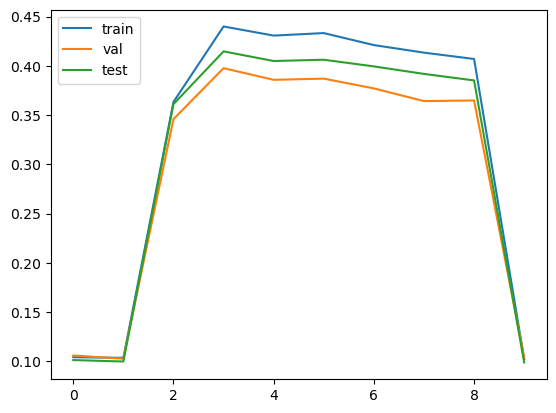

In [8]:
plt.plot(metrics["train"], label="train")
plt.plot(metrics["val"], label="val")
plt.plot(metrics["test"], label="test")

plt.legend()
plt.show()